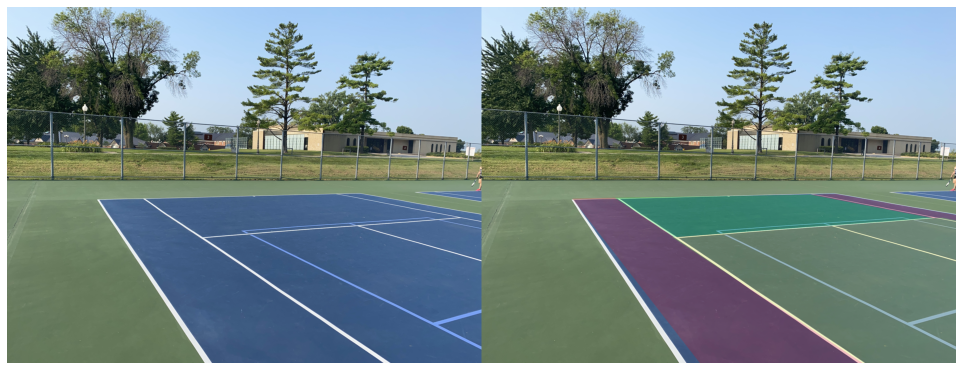

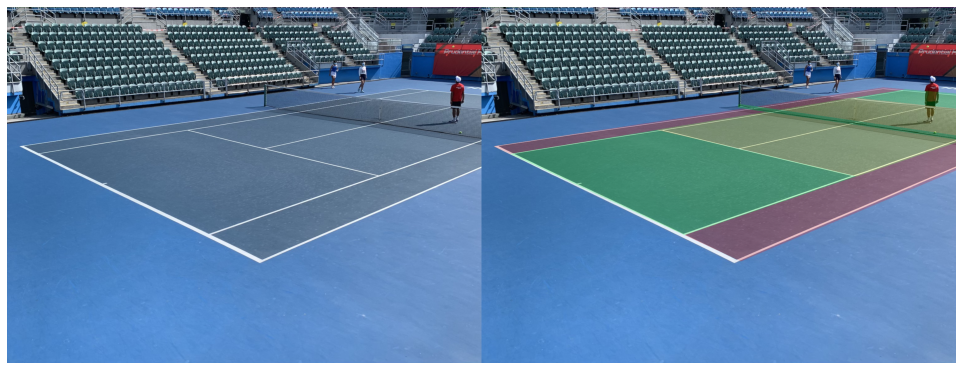

<Figure size 1224x504 with 0 Axes>

In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

image_folder = 'tennis_court_images'

alpha = .8
min_angle = .1
canny_threshold0 = 760
canny_threshold1 = 325
max_line_gap_weight = 200
hough_threshold_weight = 2
dilation_level_weight = 200
min_line_distance_weight = 3
max_homography_error_weight = 140000
net_line_detection_width_weight = 100
redundant_point_max_difference_weight = 20
maximum_allowable_point_to_line_fulcrum_distance = 3
t_detection_maximum_allowable_point_to_line_distance = 2
            
def process_image(image):
    court_points = []
    rgb_image = cv2.cvtColor(cv2.imread(image_folder+'/'+image), cv2.COLOR_BGR2RGB)
    image_width, image_height, _ = rgb_image.shape
    max_line_gap = image_width/max_line_gap_weight
    dilation_level = round(image_width/dilation_level_weight)
    hough_threshold = round(image_width/hough_threshold_weight)
    min_line_distance = image_width/min_line_distance_weight
    net_line_detection_width = round(image_width/net_line_detection_width_weight)
    max_homography_error = image_width*image_height/max_homography_error_weight
    redundant_point_max_difference = round(image_width/redundant_point_max_difference_weight)
    detected_lines = cv2.HoughLinesP(cv2.dilate(cv2.Canny(cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY), canny_threshold0, canny_threshold1), np.ones((dilation_level, dilation_level))), 1, np.pi/180, hough_threshold, None, min_line_distance, max_line_gap)
    number_of_lines = len(detected_lines)
    
    for i in range(number_of_lines):
        for j in range(i+1, number_of_lines):
            line0 = detected_lines[i][0]
            line1 = detected_lines[j][0]
            line0_x0 = line0[0]
            line0_x1 = line0[2]
            line1_x0 = line1[0]
            line1_x1 = line1[2]
            line0_x_diff = line0_x1 - line0_x0
            line1_x_diff = line1_x1 - line1_x0

            if line0_x_diff != 0 and line1_x_diff != 0:
                line0_y0 = line0[1]
                line0_y1 = line0[3]
                line1_y0 = line1[1]
                line1_y1 = line1[3]
                m0 = (line0_y1 - line0_y0)/line0_x_diff
                m1 = (line1_y1 - line1_y0)/line1_x_diff
                angle = np.arctan((m1 - m0)/(1 + m0*m1))

                if abs(angle) > min_angle:
                    b0 = line0_y0 - line0_x0*m0
                    b1 = line1_y0 - line1_x0*m1

                    for point_in_first_line in [True, False]:
                        for first_point in [True, False]:
                            if point_in_first_line:
                                point_line = line0
                                line_x0 = line1[0]
                                line_y0 = line1[1]
                                line_x1 = line1[2]
                                line_y1 = line1[3]
                                m = m1
                                b = b1
                            else:
                                point_line = line1
                                line_x0 = line0[0]
                                line_y0 = line0[1]
                                line_x1 = line0[2]
                                line_y1 = line0[3]
                                m = m0
                                b = b0

                            if first_point:
                                point_x = point_line[0]
                                point_y = point_line[1]
                            else:
                                point_x = point_line[2]
                                point_y = point_line[3]

                            if ((point_x > line_x0 and point_x < line_x1) or (point_x > line_x1 and point_x < line_x0)) and ((point_y > line_y0 and point_y < line_y1) or (point_y > line_y1 and point_y < line_y0)) and abs(point_y - point_x*m - b) < t_detection_maximum_allowable_point_to_line_distance:
                                add_point = True

                                for court_point in court_points:
                                    if ((point_x - court_point['point_x'])**2 + (point_y - court_point['point_y'])**2)**.5 < redundant_point_max_difference:
                                        add_point = False

                                if add_point:
                                    court_points.append({'point_x': point_x, 'point_y': point_y, 'm0': m0, 'm1': m1, 'b0': b0, 'b1': b1})

    if len(court_points) == 7:
        fulcrum_point_index = 0
        four_set_found = False
        
        while fulcrum_point_index < 7 and not four_set_found:
            slope0_court_point_indices = [fulcrum_point_index]
            slope1_court_point_indices = [fulcrum_point_index]
            four_points_on_line = []
            three_points_on_line = []

            for comparitor_index in range(7):
                if fulcrum_point_index != comparitor_index:
                    if abs(court_points[fulcrum_point_index]['m0']*court_points[comparitor_index]['point_x'] + court_points[fulcrum_point_index]['b0'] - court_points[comparitor_index]['point_y']) < maximum_allowable_point_to_line_fulcrum_distance:
                        slope0_court_point_indices.append(comparitor_index)
                        
                    if abs(court_points[fulcrum_point_index]['m1']*court_points[comparitor_index]['point_x'] + court_points[fulcrum_point_index]['b1'] - court_points[comparitor_index]['point_y']) < maximum_allowable_point_to_line_fulcrum_distance:
                        slope1_court_point_indices.append(comparitor_index)
            
            if len(slope0_court_point_indices) == 4:
                four_set_found = True
                
                for i in range(7):
                    if i in slope0_court_point_indices:
                        four_points_on_line.append(court_points[i])
                    else:
                        three_points_on_line.append(court_points[i])        
            elif len(slope1_court_point_indices) == 4:
                four_set_found = True
                
                for i in range(7):
                    if i in slope1_court_point_indices:
                        four_points_on_line.append(court_points[i])
                    else:
                        three_points_on_line.append(court_points[i])
            else:          
                fulcrum_point_index += 1
                
            if four_set_found:
                ordered_detected_points = [[point['point_x'], point['point_y']] for point in sorted(four_points_on_line, key=lambda point: point['point_x']) + sorted(three_points_on_line, key=lambda point: point['point_x'])]
                known = [[0, 0], [1372, 0], [9601, 0], [10973, 0], [1372, 5486], [5486, 5486], [9601, 5486]]
                npa_ordered_detected_points = np.array(ordered_detected_points)
                h, _ = cv2.findHomography(np.array(known), npa_ordered_detected_points)
                flattened_detected_points = npa_ordered_detected_points.flatten()
                predict_known = np.array([point[0] for point in cv2.perspectiveTransform(np.array([[point] for point in known], dtype=float), h)]).flatten()
                homography_error = 0
                
                for i in range(len(predict_known)):
                    homography_error += abs(flattened_detected_points[i] - predict_known[i])
                    
                if homography_error < max_homography_error:
                    detected_and_predicted = np.array(ordered_detected_points + [point[0] for point in cv2.perspectiveTransform(np.array([[point] for point in [[-700, 11887], [0, 11887], [1372, 11887], [5486, 11887], [9601, 11887], [10973, 11887], [11673, 11887], [1372, 18288], [5486, 18288], [9601, 18288], [0, 23774], [1372, 23774], [9601, 23774], [10973, 23774]]], dtype=float), h)], dtype=int)
                    detection_image = rgb_image.copy()

                    for back_rectangle in [[1, 2, 6, 4], [14, 16, 19, 18]]:
                        cv2.fillPoly(detection_image, [np.array([detected_and_predicted[back_rectangle_index] for back_rectangle_index in back_rectangle])], (0, 255, 0))

                    for lane in [[0, 1, 9, 8], [8, 9, 18, 17], [2, 3, 12, 11], [11, 12, 20, 19]]:
                        lane_coordinates = np.array([detected_and_predicted[lane_index] for lane_index in lane])

                        if all(coordinate > 0 for coordinate in lane_coordinates.flatten()):
                            cv2.fillPoly(detection_image, [lane_coordinates], (255, 0, 0))

                    for front_squares in [[4, 5, 10, 9], [9, 10, 15, 14], [5, 6, 11, 10], [10, 11, 16, 15]]:
                        front_square_coordinates = np.array([detected_and_predicted[front_square_index] for front_square_index in front_squares])

                        if all(coordinate > 0 for coordinate in front_square_coordinates.flatten()):
                            cv2.fillPoly(detection_image, [front_square_coordinates], (255, 255, 0))

                    cv2.line(detection_image, (detected_and_predicted[7][0], detected_and_predicted[7][1]), (detected_and_predicted[13][0], detected_and_predicted[13][1]), (0, 255, 0), net_line_detection_width)
                    plt.axis('off')
                    plt.imshow(np.concatenate((rgb_image, cv2.addWeighted(rgb_image, alpha, detection_image, 1-alpha, 0)), axis=1))
                    plt.figure()

plt.rcParams['figure.figsize'] = 17, 7
    
for image in os.listdir(image_folder):
    process_image(image)